## Diseño de un photon sieve con Diffractio

**Autor**: Luis Miguel Sánchez Brea

**Fecha**: 06/10/2021

**Objetivo**: Nanoroom y Teluro - Desarrollar un procedimiento de optimización para photon-sieves y otras máscaras.

**Descripción**:

Mediante una función se generan las posiciones y radios de un photon_sieve. El algoritmo inicial es de Javier Alda, pero lo he adaptado a python. Mediante otra función se crea una máscara con estas posiciones y radios. Se propaga hasta la distancia focal y se observa la distribución de intensidad.

Se obtienen algunos parámetros para poder determinar si el foco es bueno o malo:
1. intensidad máxima del foco (poco tolerante)
1. intensidad fuera de un radio determinado
1. parámetro de strehl, por hacer.

Finalmente muevo la posición de observación alrededor del foco (el tamaño será mayor) y se verifica que en esa posición estamos en un mínimo / máximo, según la función.



1. Generación de posiciones y radios
1. Creación de la máscara a partir de los datos de posiciones y radios
1. Determinacion de la distribución de intensidad en el punto focal
1. Obtención de parámetros del punto focal
1. Optimización

## Importación de módulos

In [1]:
from diffractio import np, sp, plt
from diffractio import mm, um, nm, degrees

from diffractio.scalar_masks_XY import Scalar_mask_XY
from diffractio.utils_math import nearest

number of processors: 32
total memory        : 62.8 Gb
available memory    : 84 %
max frequency       : 3400 GHz


## Generación de las posiciones y radios

In [2]:
def get_photon_sieve_positions(focal, wavelength, r_min, factor, alpha0):
    """Determines the positions and radii of the holes for a photon-sieve lens.

    Parameters:
        focal  (float): focal distance of the lens
        wavelength  (float): design wavelength
        r_min  (float): minimum hole raidus
        factor  (float): factor de desbordamiento de la zona por el agujero (busaremos un valro optimo en un paso posterior de optmización)
        alpha0  (float): valor de la fase en posición para comenzar a colocar agujeros.

    Returns:
        x_sieves (np.array): x positions of holes
        y_sieves (np.array): y positions of holes
        R_sieves (np.array): radiii of holes
     """


    # a partir de estos valores se puede extraer el valor de la zona de Fresnel de mayor orden

    jmax_rmin = np.floor( wavelength*focal/(8*r_min**2));

    #corresponde al valor de separación entre agujeros (es una banda de seguridad para 
    g=20*um; 

    jmax_g = np.floor((wavelength*focal)/(4*g**2));

    # es el mínimo entre los dos anteiores
    jmax=min([jmax_rmin, jmax_g]) 



    jmax=int(jmax)

    # una vez obtenido el valor del orden máximo de las zonas de fresnel
    # ya podemos comenzar a generar los centros y los radios de esas zonas  
    # zona 1es la zona más sencilla, corresponde a un solo agujero con tamaño igual ala primera zona

    m0=1;
    R=[np.sqrt(wavelength*focal),]
    x=[0,]
    y=[0,]

    # zonas impares

    #ii_impares=[3:2:jmax];
    ii_impares=range(3,jmax,2)

    r=[]
    rho=[]
    nn=[]
    n=[]
    resto=[]
    deltaalfafinal=[]

    alpha=[]
    xzona=[]
    yzona=[]

    R_sieves=[]
    x_sieves=[]
    y_sieves=[]

    x_sieves.append(0)
    y_sieves.append(0)
    R_sieves.append(np.sqrt(wavelength*focal))

    for jj,__ in enumerate(ii_impares):
        # longitud de la lista de valores de radios, y posiciones de agujeros antes de empezar a calcular para la zona
        m0=len(R); 

        j=ii_impares[jj];

        r_new=factor*0.5*(np.sqrt(j+1)-np.sqrt(j))*np.sqrt(wavelength*focal); # radio del agujero;
        r.append(r_new)

        rho_new=0.5*(np.sqrt(j+1)+np.sqrt(j))*np.sqrt(wavelength*focal);
        rho.append(rho_new)

        deltaalfacong=2*np.arcsin( (r[jj]+g)/rho[jj]); # rango angular del agujero incluyendo la banda g

        # calculo del número de agujeros en cada zona de Fresnel
        nn_new=(2*np.pi)/(deltaalfacong);  # fraccion entre 2pi y lo que ocupa una zona
        nn.append(nn_new)

        n_new=int(np.floor(nn[jj]));  # numero de zonas (número entero)
        n.append(n_new)

        resto_new=np.mod(nn[jj],1);
        resto.append(resto_new)

        # deltaalfafinal[jj]=deltaalfacong+(nn[jj]/n[jj])-1;
        deltaalfafinal_new=deltaalfacong*(1+resto[jj]/n[jj]);
        deltaalfafinal.append(deltaalfafinal_new)


        for kk,_ in enumerate(range(n_new)):
            alpha_new=deltaalfafinal[jj]*kk+ alpha0 # posiciones angulares de los agujeros
            alpha.append(alpha_new)

            xzona_new=rho_new*np.sin(alpha_new)# posiciones x de los agujeros
            yzona_new=rho_new*np.cos(alpha_new) # posiciones x de los agujeros

            xzona.append(xzona_new)
            yzona.append(yzona_new)


            R_new=r_new
            R_sieves.append(R_new)
            x_sieves.append(xzona_new)
            y_sieves.append(yzona_new)

    x_sieves=np.array(x_sieves)
    y_sieves=np.array(y_sieves)
    R_sieves=np.array(R_sieves)    
    return x_sieves, y_sieves, R_sieves

In [3]:
# Parámetros 
wavelength=0.6328*um
focal = 100*mm
r_min = 5*um
factor=1; # factor de desbordamiento de la zona por el agujero (busaremos un valro optimo en un paso posterior de optmización)
alpha0=0; # valor de la fase en posición para comenzar a colocar agujeros.


In [4]:
x_sieves, y_sieves, r_sieves=get_photon_sieve_positions(focal, wavelength, r_min, factor, alpha0)

## Creación de la máscara

In [5]:
x_max=x_sieves.max()+20*um
num_pixels=1024

x0=np.linspace(-x_max,x_max,num_pixels)
y0=np.linspace(-x_max,x_max,num_pixels)

ps=Scalar_mask_XY(x0,y0,wavelength)


In [6]:
def photon_sieve_1(self, x_centers, y_centers, radii_holes):
    
    t_circle=Scalar_mask_XY(self.x,self.y,self.wavelength)
    ps0=Scalar_mask_XY(self.x,self.y,self.wavelength)
    radii_u=np.unique(radii_holes)
    
    for i,radius in enumerate(radii_u):
        i_radii = radii_holes==radius
        t_circle.clear_field()
        t_circle.circle(r0=(0,0),radius=radius)
        ps0.clear_field()
        xi=x_centers[i_radii]
        yi=y_centers[i_radii]
        r0=np.vstack((xi,yi))
        ps0.photon_sieve(t1=t_circle,r0=r0)
        self.u=self.u+ps0.u
    
    return self

In [7]:
ps=photon_sieve_1(ps,x_sieves, y_sieves, r_sieves)

In [8]:
ps.draw(filename='ps_python.png');

In [9]:
ps.save_mask(filename='ps_python.bmp');

## Lente estándard con los mismos parámetros

In [10]:
lens_standard=Scalar_mask_XY(x0,y0,wavelength)
lens_standard.lens(r0=(0,0), radius=x0[-1], focal=focal, angle=0.0, mask=True)

u_lens_standard_focus=lens_standard.RS(z=focal,verbose=True)

size=400
u_lens_standard_focus.cut_resample(x_limits=(-size/2,size/2),y_limits=(-size/2,size/2), new_field=False)
u_lens_standard_focus.draw(has_colorbar='vertical')

mask_standard_lens=u_lens_standard_focus

Good result: factor 6.61


## Determinacion de la distribución de intensidad en el punto focal

In [11]:
%%time
u2=ps.RS(z=focal+0*mm,verbose=True)
u2.cut_resample(x_limits=(-size/2,size/2),y_limits=(-size/2,size/2), new_field=False)


Good result: factor 6.61
CPU times: user 1.95 s, sys: 1.95 s, total: 3.9 s
Wall time: 1.59 s


In [12]:
u2.draw(has_colorbar='vertical')


(<Figure size 500x500 with 2 Axes>,
 <AxesSubplot:xlabel='$x  (\\mu m)$', ylabel='$y  (\\mu m)$'>,
 <matplotlib.image.AxesImage at 0x7f61894cb5f8>)

## Obtención de parámetros de la distribución de intensidad

In [13]:
def intensity_max(u, verbose=False):
    intensity_focus=u.intensity()
    intensity_max=intensity_focus.max()
    if verbose:
        print("I_max = {2.2f}".format(intensity_max))
    return intensity_max

In [14]:
def intensity_out(u, radius_out, size=0, mask=None, has_draw=False, verbose=False):
    if size>0:
        u3=u.cut_resample(x_limits=(-size/2,size/2),y_limits=(-size/2,size/2), new_field=True)
    else: 
        u3=u
        size=u.x[-1]
    
    if has_draw:
        u3.draw(logarithm=True)        
        u3.draw_profile([-size,0], [size,0]);

    intensity_focus=u3.intensity()
    intensity_max=intensity_focus.max()        
        
    i_x_max,_,_=nearest(u3.x,0)
    i_y_max,_,_=nearest(u3.y,0)        

    #forma sencilla
    I_optimal=np.zeros_like(u3.u, dtype=float)
    I_optimal[i_y_max,i_x_max]=intensity_max
    mask_size = intensity_focus.size
    
    if mask is None:
        #forma más elaborada
        mask=Scalar_mask_XY(u3.x,u3.y,u3.wavelength)
        mask.circle(r0=(0,0), radius=radius_out)
        mask.inverse_amplitude()
        
    if has_draw:
        mask.draw()
        plt.title('mask')

    mask_size=mask.u.sum()
    error=np.real((mask.u*(intensity_focus-I_optimal)).sum()/mask_size)
    
    if verbose:
        print("error = {:2.2f}".format(error))
    
    return error, mask

### Ejemplo

error = 0.89


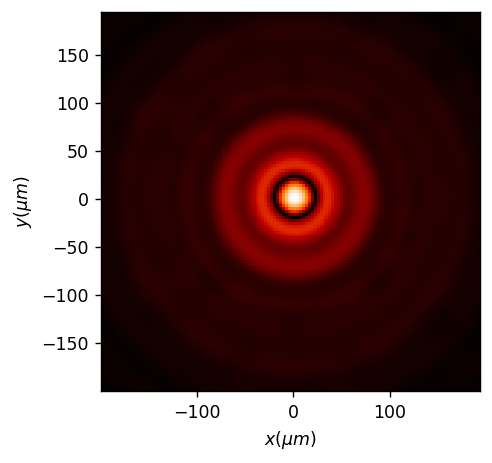

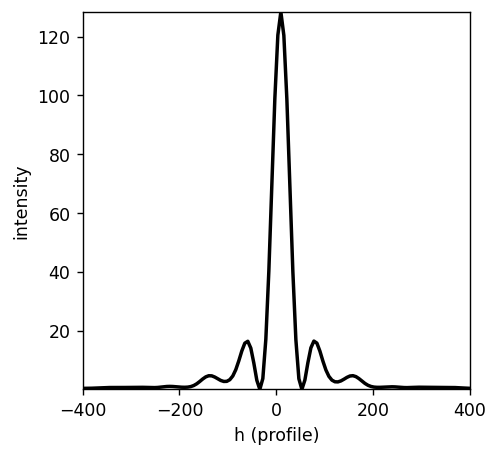

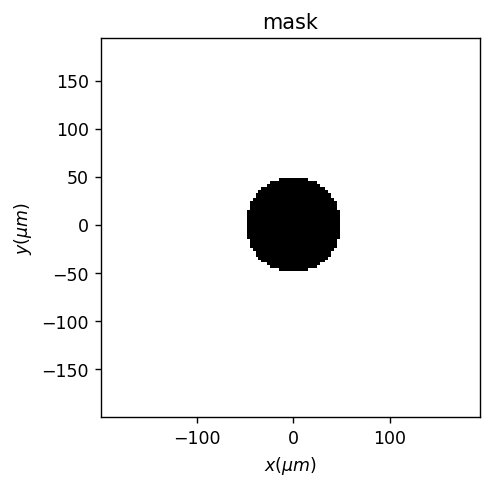

In [15]:
error, mask=intensity_out(u2, radius_out=50, size=size,  mask=None, has_draw=True, verbose=True)

## Optimización

Realmente esto no es una optimización. Aquí lo que estamos cambiando no es la máscara, sino la distancia z de focalización, por eso sale el mínimo en $\Delta$z=0.

In [16]:
deltas_z=np.linspace(-5*mm,5*mm,21)
errores_out=np.zeros_like(deltas_z,dtype=float)
intensities_max=np.zeros_like(deltas_z,dtype=float)

In [17]:
for i,dz in enumerate(deltas_z):
    u2=ps.RS(z=focal+dz,verbose=False)
    error, mask=intensity_out(u2, radius_out=50, size=size,  mask=None, has_draw=False, verbose=False)
    
    errores_out[i]=error
    intensities_max[i]=intensity_max(u2, verbose=False)

Text(0, 0.5, 'error')

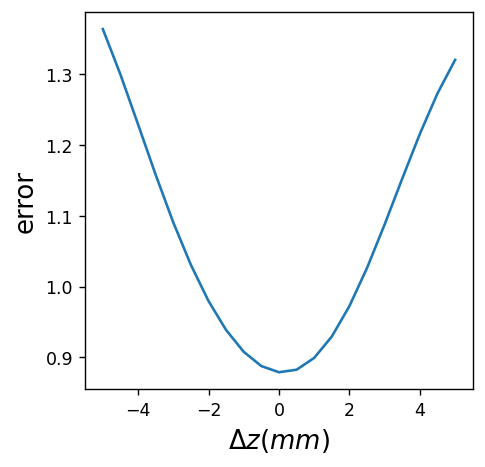

In [18]:
plt.plot(deltas_z/mm,errores_out)
plt.xlabel(u'$\Delta z (mm)$',fontsize=15)
plt.ylabel('error',fontsize=15)

Text(0, 0.5, '$I_{max}$')

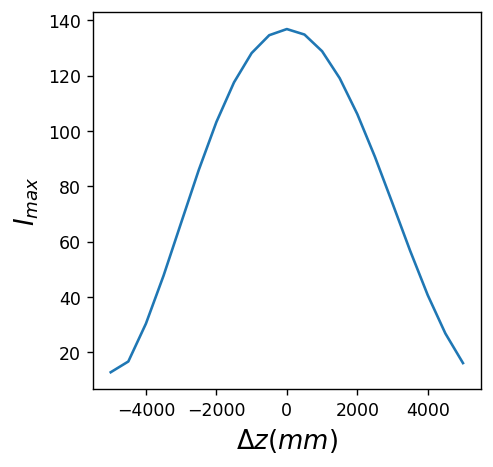

In [19]:
plt.plot(deltas_z,intensities_max)
plt.xlabel(u'$\Delta z (mm)$',fontsize=15)
plt.ylabel('$I_{max}$',fontsize=15)